<div style = "text-align:center">
    <font size=6 color="darkgreen"> 
        CIR Model to Simulate Changes in Interest Rates and Liability Hedging

<font size=2 color="darkblue"> The Cox Ingersoll Ross model is used to model the dynamics of interest rates, and is an extension of the popular Vasicek Model to prevent negative interest rate:

<font color="green">$$dr_t = a(b-r_t)dt + \sigma\sqrt{r_t} dW_t$$
    
    where
- $dr_t$ = small chages to the interest rates
- $b$ = long-term mean interest rate
- $r_t$ = current interest rate
- $a$ = scale with the distance between $b$ and $r_t$ 
- $\sigma$ = scalling factor(volatility)
- $\sqrt{r_t}$ = prevent the negative interest rates, if you ignore this part you will get Vasicek Model

- $b-r_t$ measures how far you are away from the long term mean interest rate
- $a$ measures how fast

## Short Rate vs Annualized 

<font color = "darkgreen">$$ (1+\frac{r}{N})^N$$

In [1]:
(1+1/100000)**100000

2.7182682371922975

As N becomes very large

$$1+r_{annual} = e^{r_{instant}}$$


$$r_{annual} = e^{r_{inst}} - 1$$ 


$$r_{inst} = Ln(1+r_{annual})$$

In [2]:
import numpy as np
import pandas as pd
import edhec_risk_ins as eri
%load_ext autoreload
%autoreload 2

In [3]:
def inst_to_ann(r):
    """
    Convert short rate to annualized rate
    """
    return np.expm1(r)
#equals to the function exp(r)-1
#more efficient

def ann_to_inst(r):
    """
    convert annualized rate to short rate
    """
    return np.log1p(r)

In [5]:
ann_to_inst(-0.01)

-0.010050335853501442

<font color="darkred">$$dr_t = a(b-r_t)dt + \sigma\sqrt{r_t} dW_t$$

In [6]:
def cir(n_years=10,n_scenarios=1,a=0.05,b=0.03,sigma=0.05,steps_per_year=12,r_0=None):
    """
    Implements the CIR model for instant rates
    parameters: r_0 is the starting rate (since the drt measures the change)that defaulted as none 
    and if the no rate is assigned to the r_0 then it will just be the long term mean "b"
    """
    if r_0 is None: r_0 = b
    r_0 = ann_to_inst(r_0) #in reality the annulized return and the instant rate not too different
    dt=1/steps_per_year
    
    num_steps = int(n_years*steps_per_year)+1
    shock=np.random.normal(0,scale=np.sqrt(dt),size=(num_steps,n_scenarios))
    rates = np.empty_like(shock) #empty array with the same dimension of shock
    rates[0] =r_0
    
    for step in range(1,num_steps):
        r_t = rates[step-1]
        d_r_t = a*(b-r_t)*dt + sigma*np.sqrt(r_t)*shock[step]
        rates[step] =abs(r_t + d_r_t)
        
    return pd.DataFrame(data=inst_to_ann(rates), index=range(num_steps))

In [7]:
%matplotlib inline

In [9]:
cir(n_scenarios=5)

,0,1,2,3,4
0,0.030000,0.030000,0.030000,0.030000,0.030000
1,0.034681,0.033182,0.030884,0.033308,0.032667
2,0.038151,0.032953,0.034992,0.036748,0.031282
3,0.036937,0.031852,0.035909,0.037496,0.031950
4,0.036727,0.031248,0.037260,0.034327,0.033165
...,...,...,...,...,...
116,0.040818,0.095505,0.018781,0.013826,0.068355
117,0.045446,0.106688,0.019530,0.014335,0.066404
118,0.043699,0.102557,0.020135,0.015990,0.066010
119,0.044323,0.098467,0.018710,0.017751,0.063509


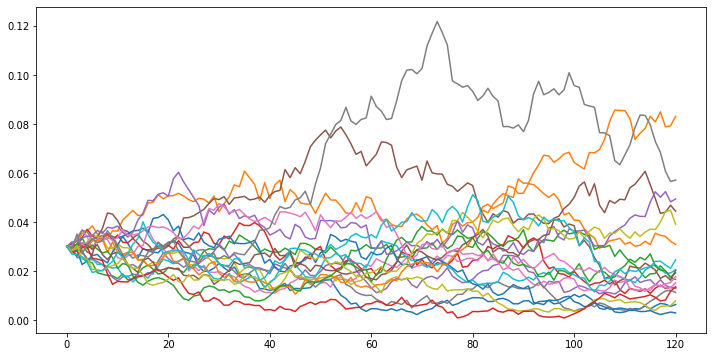

In [10]:
cir(n_scenarios=20).plot(figsize=(12,6),legend=False)

In [11]:
def show_cir(r_0=.03,a=.5,b=.03,sigma=.05,n_scenarios=5):
    cir(r_0=r_0,a=a,b=b,sigma=sigma,n_scenarios=n_scenarios).plot(figsize=(12,6),legend = False)
    
import ipywidgets as widgets
from IPython.display import display

controls = widgets.interactive(show_cir,
                              r_0 = (0,.15,.01),
                              a = (0, 1, .1),
                              b = (0,.15,.01),
                              sigma = (0,.1,.001),
                              n_scenarios = (1,100))
display(controls)

interactive(children=(FloatSlider(value=0.03, description='r_0', max=0.15, step=0.01), FloatSlider(value=0.5, …

The model can also be used to generate the movement of bond price for a zero coupon bond prices are implied by the generated interest rate, using the followiing equations

<font color = "darkblue"> $$P(t,T) = A(t,T)e^{-B(r,T)r_t}$$

where
$$ A(t,T) = (\frac{2he^{(a+h)\tau/2}}{2h+(a+h)(e^{\tau h} - 1)})^{2ab/\sigma^2}$$

$$B(t,T)=\frac{2(e^{\tau h} - 1)}{2h+(a+h)(e^{\tau h} -1)}$$

$$h = \sqrt{a^2+2\sigma^2}$$ 

$$ \tau = T- t $$

In [22]:
import math 
def cir(n_years=10,n_scenarios=10, a=0.05,b=0.03,sigma=0.05,steps_per_year=12,r_0=None):
    """
    Generate random interest rate rate evolution over timeusing the CIR model
    b and r_0 are assumed to be the annualized rates, not the short rate
    and the returned values are the annualized rates as well
    """
    if r_0 is None: r_0 = b
    r_0 = ann_to_inst(r_0)
    dt=1/steps_per_year
    
    num_steps = int(n_years*steps_per_year)+1
    shock=np.random.normal(0,scale=np.sqrt(dt),size=(num_steps,n_scenarios))
    rates = np.empty_like(shock)
    rates[0] =r_0
    
    ## for price generation
    h = math.sqrt(a**2 + 2*sigma**2)
    prices = np.empty_like(shock)
    ####
     
    def price(ttm, r):
        _A = ((2*h*math.exp((h+a)*ttm/2))/(2*h+(h+a)*(math.exp(h*ttm)-1)))**(2*a*b/sigma**2)
        _B = (2*(math.exp(h*ttm)-1))/(2*h + (h+a)*(math.exp(h*ttm)-1))
        _P = _A*np.exp(-_B*r)
        return _P
    prices[0] = price(n_years, r_0)
                                          
    for step in range(1,num_steps):
        r_t = rates[step-1]
        d_r_t = a*(b-r_t)*dt + sigma*np.sqrt(r_t)*shock[step]
        rates[step] = abs(r_t + d_r_t)
        # generate prices at time t as well
        prices[step] = price(n_years-step*dt, rates[step])
                        
    rates = pd.DataFrame(data=inst_to_ann(rates),index=range(num_steps))
    ### for prices 
    prices = pd.DataFrame(data=prices,index=range(num_steps))
    ### 
    return rates, prices                  

In [13]:
def show_cir_prices(r_0=0.03,a=0.5,b=0.03,sigma=0.05,n_scenarios=5):
    cir(r_0=r_0,a=a,b=b,sigma=sigma,n_scenarios=n_scenarios)[1].plot(figsize=(12,6),legend=False)

controls=widgets.interactive(show_cir_prices,
                            r_0 = (0,.15, .01),
                            a=(0,1,.1),
                            b=(0,.15,.01),
                            sigma=(0,.1,.01),
                            n_scenarios=(1,100))
display(controls)

interactive(children=(FloatSlider(value=0.03, description='r_0', max=0.15, step=0.01), FloatSlider(value=0.5, …

In [23]:
a_0 = .75 #current wealth 0.75 million
rates, bond_prices = cir(n_years=10,r_0=0.03, b =0.03,n_scenarios=10)
liabilities = bond_prices
zcbond_10 = pd.Series(data=[1],index=[10]) #zc coupon bond in 10 years
zc_0 = eri.pv(zcbond_10,r=.03)
n_bonds = a_0 / zc_0
assetValue_zc_bonds = n_bonds*bond_prices
assetValue_cash = a_0*(rates/12 + 1).cumprod()

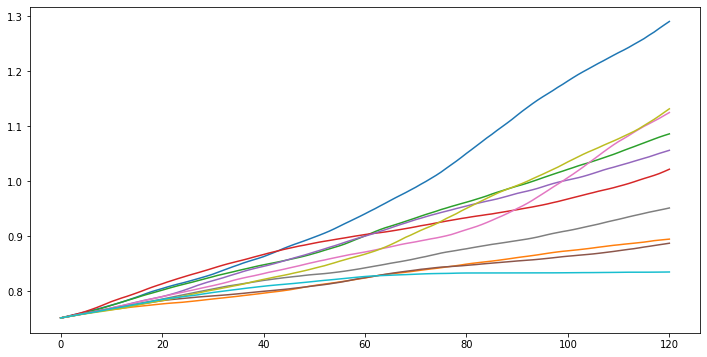

In [24]:
assetValue_cash.plot(figsize=(12,6),legend= False)
#put money into the cash is not super safe as we can see that the graph below, some scenarios are below 1 and unable to cover the liabilities

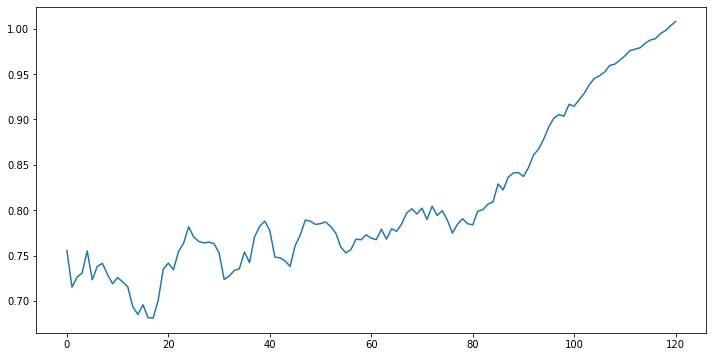

In [25]:
assetValue_zc_bonds.plot(figsize=(12,6),legend= False)
# In the end all scenarios are equal to 1

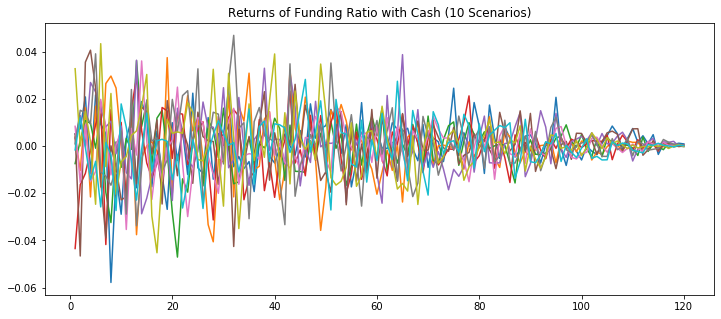

In [17]:
(assetValue_cash/liabilities).pct_change().plot(title='Returns of Funding Ratio with Cash (10 Scenarios)',legend=False,figsize=(12,5))

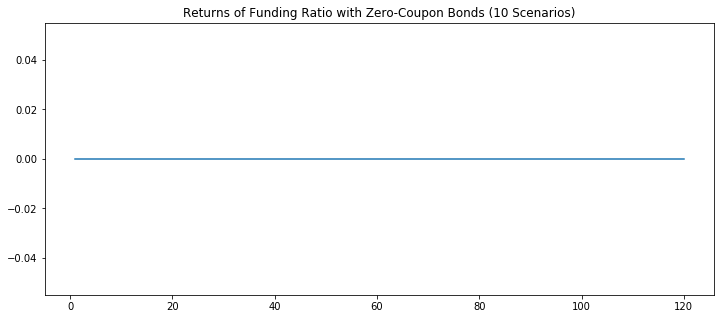

In [18]:
(assetValue_zc_bonds/liabilities).pct_change().plot(title='Returns of Funding Ratio with Zero-Coupon Bonds (10 Scenarios)',legend=False,figsize=(12,5))

In [46]:
a_0 = .35
rates, bond_prices = cir(n_scenarios=10000,r_0=.03,b=.03)
liabilities = bond_prices
zc_0 = eri.pv(zcbond_10,.03)
n_bonds = a_0 / zc_0
av_zc_bonds = n_bonds * bond_prices
av_cash = a_0*(rates/12 + 1).cumprod()

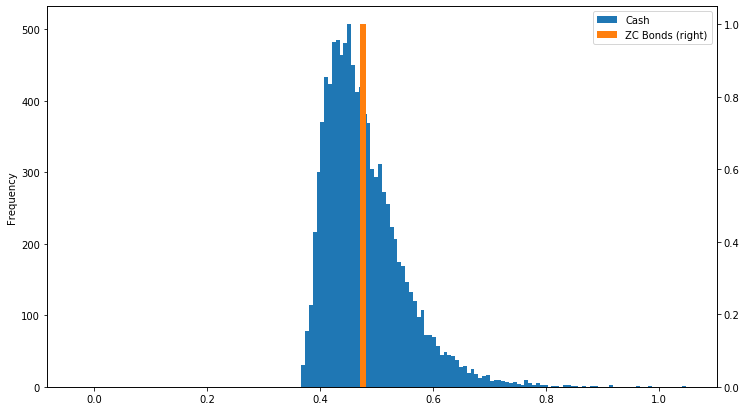

In [47]:
tfr_cash = av_cash.iloc[-1]/liabilities.iloc[-1] #terminal funding ratio, iloc is integer index and the -1 means the last one
tfr_zc_bonds = av_zc_bonds.iloc[-1]/liabilities.iloc[-1]
tfr_cash.plot.hist(label="Cash",figsize=(12,7),legend = True, bins=100)
tfr_zc_bonds.plot.hist(label="ZC Bonds",legend=True,bins=100,secondary_y=True)
#the terminal funding ration in 10 years of putting cash or putting zc bond